<a href="https://colab.research.google.com/github/pratibhavhegde/pratibhavhegde/blob/main/YOLOV9_Train_Eval_CustomData_Drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!nvidia-smi

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Tue Jul 15 06:03:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             34W /   70W |    1350MiB /  15360MiB |      0%      Default |
|                       

In [54]:
# Set home directory
import os
HOME = os.getcwd()
print(f"Working directory: {HOME}")

#with torch.amp.autocast(device_type='cuda', enabled=amp):
#ckpt = torch.load(weights, map_location='cpu', weights_only=False)  # Add weights_only=False

Working directory: /content/yolov9


In [53]:
# ---
# STAGE 0: SETUP AND ENVIRONMENT
# ---
print(">>> STAGE 0: Setting up the environment <<<")

# Explicitly set working directory to /content to try and stabilize the environment
%cd /content/
print(f"Initial working directory: {os.getcwd()}")

# Clone the YOLOv9 repository if it doesn't exist
if not os.path.exists('yolov9'):
    print("Cloning YOLOv9 repository...")
    !git clone https://github.com/WongKinYiu/yolov9.git
    print("YOLOv9 repository cloned.")
else:
    print("YOLOv9 repository already exists.")

# Install required packages and dependencies
print("Installing necessary Python packages...")
# Ensure pip commands are run relative to the correct directory if needed,
# but global install usually works from /content
!pip install -q ultralytics ensemble_boxes
!pip install -q -r yolov9/requirements.txt
!pip install -q pandas matplotlib seaborn Pillow opencv-python-headless numpy
print("Required packages installed.")

# Import all necessary libraries
import os
import yaml
import shutil
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import numpy as np
from ultralytics import YOLO
from ensemble_boxes import weighted_boxes_fusion
from IPython.display import Image, display # For displaying images in Colab


# Set YOLOv9 directory as current working directory for its scripts
# Change directory AFTER cloning
%cd /content/yolov9
print(f"Changed working directory to: {os.getcwd()}")

# Set home directory and print (moved from vE8CLdJUHEbh)
HOME = os.getcwd()
print(f"Working directory (HOME): {HOME}")

# Create a directory for analysis plots if it doesn't exist
# Create this directory *within* the yolov9 directory
if not os.path.exists(os.path.join(HOME, 'analysis_plots')):
    os.makedirs(os.path.join(HOME, 'analysis_plots'))
print(f"Created analysis_plots directory at: {os.path.join(HOME, 'analysis_plots')}")


print("✅ Environment setup complete.")

>>> STAGE 0: Setting up the environment <<<
/content
Initial working directory: /content
Cloning YOLOv9 repository...
Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 781 (delta 265), reused 257 (delta 257), pack-reused 465 (from 1)
Receiving objects: 100% (781/781), 3.25 MiB | 33.97 MiB/s, done.
Resolving deltas: 100% (339/339), done.
YOLOv9 repository cloned.
Installing necessary Python packages...
Required packages installed.
/content/yolov9
Changed working directory to: /content/yolov9
Working directory (HOME): /content/yolov9
Created analysis_plots directory at: /content/yolov9/analysis_plots
✅ Environment setup complete.


In [4]:
#mosaic: 1.0  # image mosaic (probability)
#mixup: 0.15  # image mixup (probability)
#copy_paste: 0.3  # segment copy-paste (probability)
mosaic: 0.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)----for hyp.scratch-high.yaml
#experimental.py-Line 243- ckpt = torch.load(attempt_download(w), map_location='cpu', weights_only=False)  # load
#general.py-Line 999-#x = torch.load(f, map_location=torch.device('cpu'), weights_only=False)
tran.py----Line 106----
with torch_distributed_zero_first(LOCAL_RANK):
            weights = attempt_download(weights)  # download if not found locally
        # The w variable might be incorrectly overwritten by resume logic.
        # We force it back to the original weights path from the arguments.
        w = str(opt.weights)
        print(f'Patch Applied: Forcing weights to {w}')
        ckpt = torch.load(attempt_download(w), map_location='cpu', weights_only=False)
#plots.py - Line 86 ---bbox = self.font.getbbox(label)
                w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
#train.py - Line 245--- scaler = torch.amp.GradScaler('cuda', enabled=amp)
Line 303 ---with torch.amp.autocast('cuda', enabled=amp):
#augmentation.py - Line 27 --- A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0)




!grep -n "torch.cuda.amp.GradScaler" /content/yolov9/train.py---- to search perticular keyword
!grep -n "torch.cuda.amp.autocast" /content/yolov9/train.py

In [ ]:
!grep -n " A.RandomResizedCrop" /content/yolov9/utils/dataloaders.py

In [57]:
# Install Roboflow for dataset management
!pip install -q roboflow

In [59]:
## Download Pretrained Weights

# Create weights directory
if not os.path.exists('./weights'):
    os.makedirs('./weights')

# Download YOLOv9 and GELAN weights (we'll use gelan-c for drone detection)
!wget -P ./weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P ./weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt
!wget -P ./weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P ./weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt

In [61]:
# Verify weights download
!ls -la /content/yolov9/weights

total 840744
drwxr-xr-x  2 root root      4096 Jul 15 06:10 .
drwxr-xr-x 14 root root      4096 Jul 15 06:09 ..
-rw-r--r--  1 root root  36700160 Jul 15 06:10 best.pt
-rw-r--r--  1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r--  1 root root  51508261 Feb 18  2024 gelan-c.pt.1
-rw-r--r--  1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r--  1 root root 117203713 Feb 18  2024 gelan-e.pt.1
-rw-r--r--  1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r--  1 root root 103153312 Feb 18  2024 yolov9-c.pt.1
-rw-r--r--  1 root root 140217688 Feb 18  2024 yolov9-e.pt
-rw-r--r--  1 root root 140217688 Feb 18  2024 yolov9-e.pt.1


In [8]:
!wget -P {HOME}/data -q https://source.roboflow.com/mqkdpN3J5QZGlMO6QGQRPARJZML2/Xf6lhjPzNE5skMc2Vr8Q/annotation-HelicopterHotairballoonTowerTree.png?v=2025-07-01T15:17:16.295Z

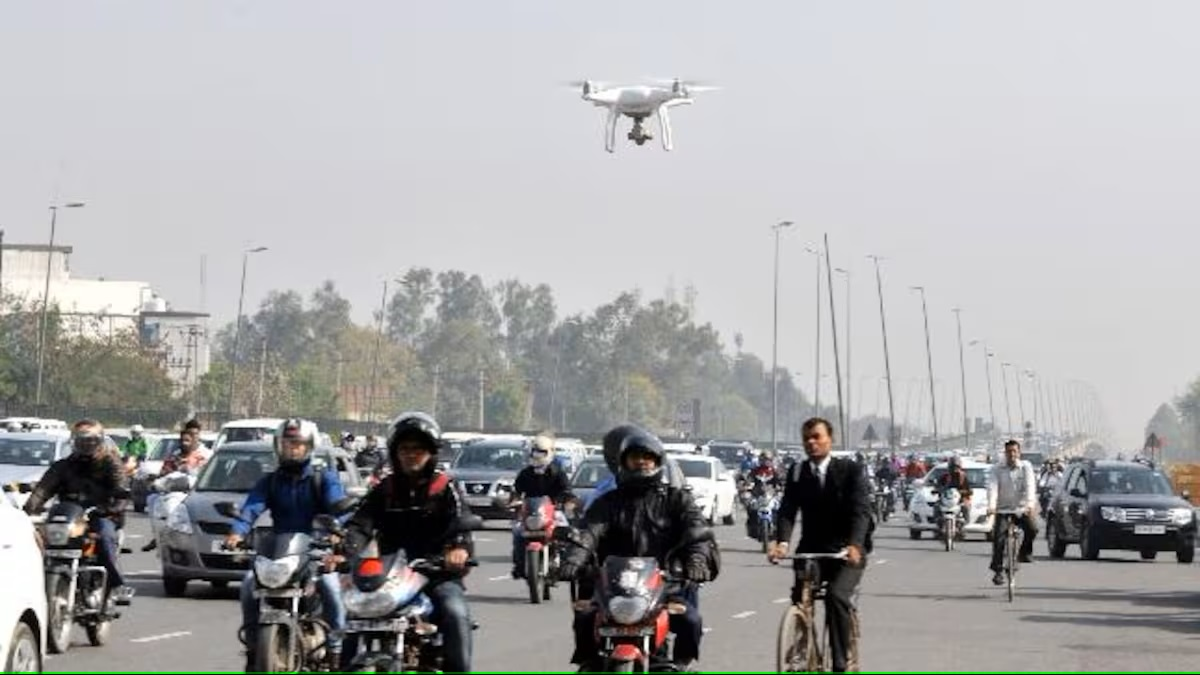

In [60]:
#Image upload path - C:\Users\PRATIBHA V HEGDE\AppData\Local\Programs\Python\Python310\Code\YOLO_V8_Images
SOURCE_IMAGE_PATH = f"/content/data/Drone_On_RoadTraffic.jpg"
from IPython.display import Image

Image(filename="/content/data/Drone_On_RoadTraffic.jpg", width=600)

In [62]:
!python /content/yolov9/detect.py --weights /content/yolov9/weights/gelan-c.pt --source /content/data/Drone_On_RoadTraffic.jpg

detect: weights=['/content/yolov9/weights/gelan-c.pt'], source=/content/data/Drone_On_RoadTraffic.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 387 layers, 25288768 parameters, 0 gradients, 102.1 GFLOPs
image 1/1 /content/data/Drone_On_RoadTraffic.jpg: 384x640 9 persons, 2 bicycles, 10 cars, 5 motorcycles, 1 airplane, 60.9ms
Speed: 0.5ms pre-process, 60.9ms inference, 168.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


Contents of /content/yolov9/runs/detect/exp/
total 236
drwxr-xr-x 2 root root   4096 Jul 15 06:11 .
drwxr-xr-x 3 root root   4096 Jul 15 06:11 ..
-rw-r--r-- 1 root root 230572 Jul 15 06:11 Drone_On_RoadTraffic.jpg


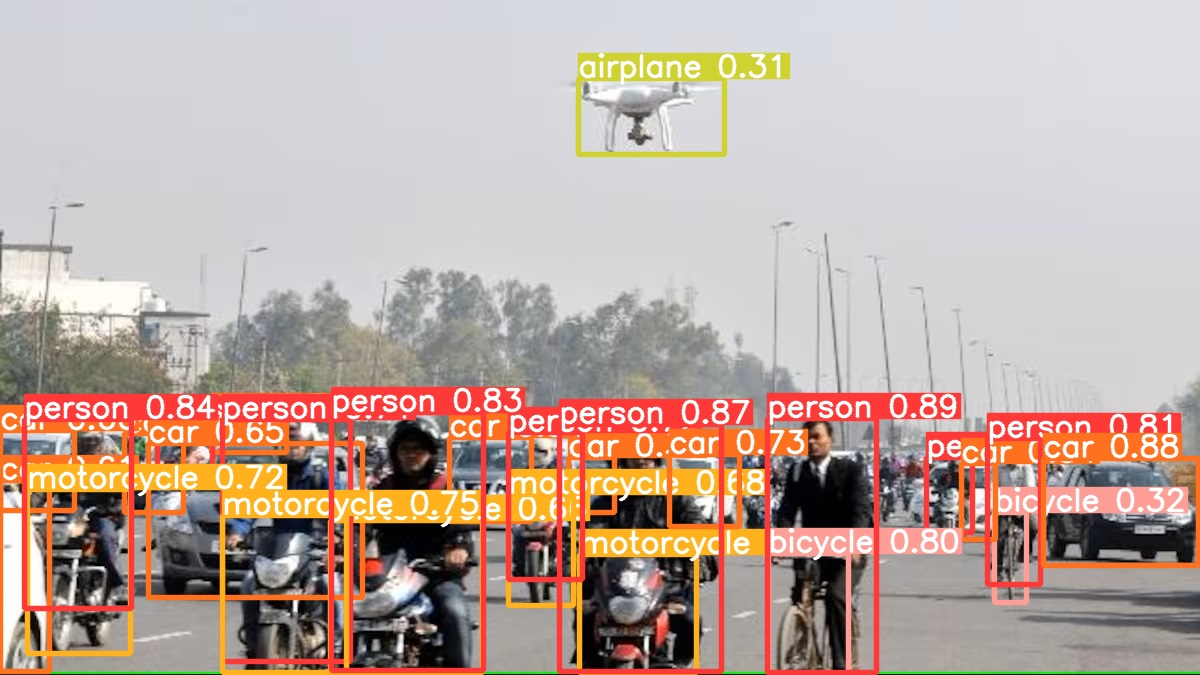

In [63]:
print(f"Contents of /content/yolov9/runs/detect/exp/")
!ls -la /content/yolov9/runs/detect/exp
from IPython.display import Image

Image(filename=f"/content/yolov9/runs/detect/exp/Drone_On_RoadTraffic.jpg", width=800)

In [74]:
!ls -lh /content/yolov9/weights/best.pt

-rw-r--r-- 1 root root 196M Jul 15 06:53 /content/yolov9/weights/best.pt


In [75]:
!python /content/yolov9/detect.py --weights /content/yolov9/weights/best.pt --source /content/data/Drone_On_RoadTraffic.jpg

detect: weights=['/content/yolov9/weights/best.pt'], source=/content/data/Drone_On_RoadTraffic.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25252531 parameters, 0 gradients, 101.9 GFLOPs
image 1/1 /content/data/Drone_On_RoadTraffic.jpg: 384x640 1 Drone, 54.7ms
Speed: 0.4ms pre-process, 54.7ms inference, 171.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp5


Contents of /content/yolov9/runs/detect/exp5/
total 172
drwxr-xr-x 2 root root   4096 Jul 15 06:53 .
drwxr-xr-x 8 root root   4096 Jul 15 06:53 ..
-rw-r--r-- 1 root root 164887 Jul 15 06:53 Drone_On_RoadTraffic.jpg


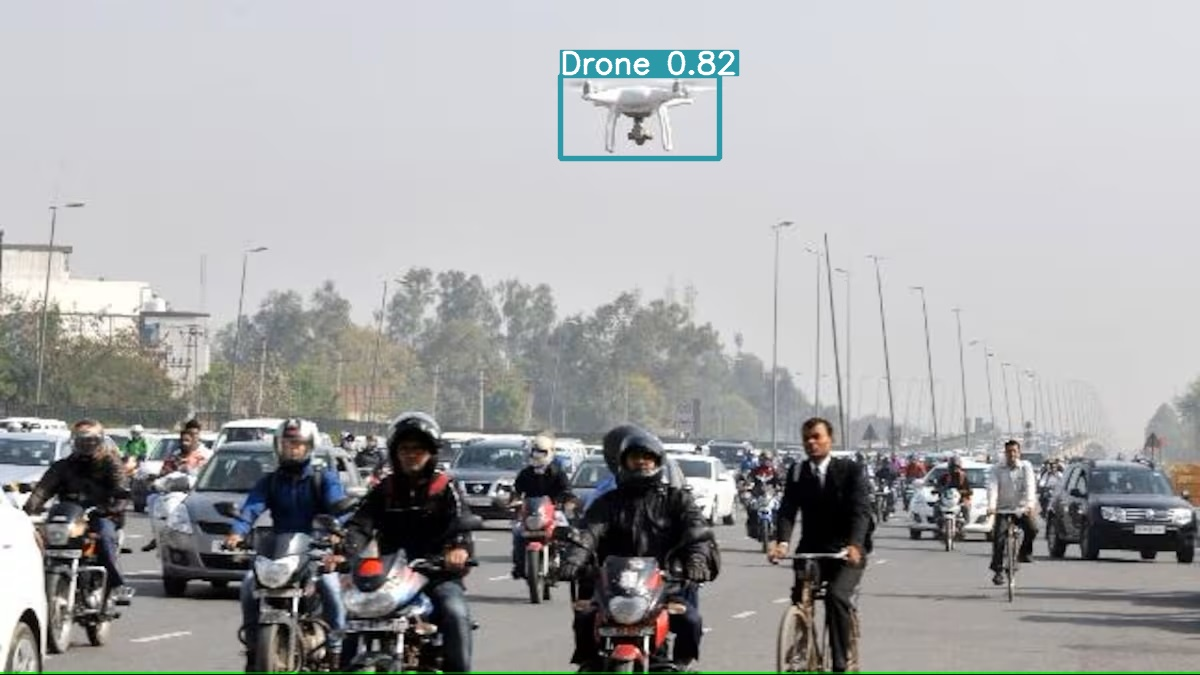

In [76]:
print(f"Contents of /content/yolov9/runs/detect/exp5/")
!ls -la /content/yolov9/runs/detect/exp5
from IPython.display import Image

Image(filename=f"/content/yolov9/runs/detect/exp5/Drone_On_RoadTraffic.jpg", width=800)

In [ ]:
# ---
# STAGE 0.5: PATCHING THE ULTRALYTICS LIBRARY
# ---
print(">>> STAGE 0.5: Applying patch to fix library incompatibility <<<")

# Define the path to the problematic file
autobackend_path = '/usr/local/lib/python3.11/dist-packages/ultralytics/nn/autobackend.py'

# Check if the file exists before trying to patch it
if os.path.exists(autobackend_path):
    # This `sed` command finds the line `model = model.fuse(verbose=verbose)`
    # and replaces it with `model = model.fuse()`, removing the incorrect argument.
    !sed -i "s/model = model.fuse(verbose=verbose)/model = model.fuse()/g" {autobackend_path}
    print(f"✅ Successfully patched {autobackend_path} to remove 'verbose' argument.")
else:
    print(f"Warning: Could not find the file to patch at {autobackend_path}. The error might persist.")
    print("This could happen if the library installation path is different.")

In [77]:
import cv2
import torch
import numpy as np
from yolov9.utils.general import non_max_suppression, scale_boxes
from yolov9.utils.plots import Annotator
from yolov9.utils.dataloaders import LoadImages
from yolov9.models.common import DetectMultiBackend

def run_detection(model, img_path, conf_thres=0.5, iou_thres=0.45):
    """Run detection with proper image loading and processing"""
    dataset = LoadImages(img_path, img_size=640, stride=32, auto=True)
    results = []

    for path, img, im0s, _, _ in dataset:  # Note the extra unpacked values
        img = torch.from_numpy(img).to(model.device)
        img = img.float() / 255.0
        if len(img.shape) == 3:
            img = img[None]  # expand for batch dim

        with torch.no_grad():
            pred = model(img, augment=False, visualize=False)
            pred = non_max_suppression(pred, conf_thres, iou_thres)[0]

        if pred is not None:
            pred[:, :4] = scale_boxes(img.shape[2:], pred[:, :4], im0s.shape).round()
            for *xyxy, conf, cls in pred:
                results.append({
                    'xyxy': [x.item() for x in xyxy],
                    'conf': conf.item(),
                    'cls': cls.item(),
                    'name': model.names[int(cls)]
                })
    return results

def combine_detections(coco_dets, custom_dets, iou_threshold=0.5):
    """Combine detections with priority to custom model"""
    final_dets = custom_dets.copy()

    for coco_det in coco_dets:
        add = True
        for custom_det in custom_dets:
            iou = calculate_iou(coco_det['xyxy'], custom_det['xyxy'])
            if iou > iou_threshold:
                add = False
                break
        if add:
            final_dets.append(coco_det)
    return final_dets

def calculate_iou(box1, box2):
    """Calculate Intersection over Union"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return inter_area / float(box1_area + box2_area - inter_area)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_coco = DetectMultiBackend('/content/yolov9/weights/gelan-c.pt', device=device)
model_custom = DetectMultiBackend('/content/yolov9/weights/best.pt', device=device)

# Process image
img_path = "/content/data/Hot_Air_Balloon1.jpg" #        Drone_On_RoadTraffic.jpg"
coco_results = run_detection(model_coco, img_path, conf_thres=0.4)
custom_results = run_detection(model_custom, img_path, conf_thres=0.5)
combined_results = combine_detections(coco_results, custom_results)

# Visualize results
frame = cv2.imread(img_path)
annotator = Annotator(frame)
for det in combined_results:
    xyxy = det['xyxy']
    label = f"{det['name']} {det['conf']:.2f}"
    color = (0, 255, 0) if det in custom_results else (0, 0, 255)  # Green for custom, red for COCO
    annotator.box_label(xyxy, label, color=color)

cv2.imwrite("/content/data/HAB_Results_Urban.jpg", annotator.result())

Fusing layers... 
Model summary: 387 layers, 25288768 parameters, 0 gradients, 102.1 GFLOPs
Fusing layers... 
gelan-c summary: 387 layers, 25252531 parameters, 0 gradients, 101.9 GFLOPs


True

>>> STAGE 0.5: Applying patch to fix library incompatibility <<<


YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)



✅ Successfully patched /usr/local/lib/python3.11/dist-packages/ultralytics/nn/autobackend.py to remove 'verbose' argument.
>>> Running main detection script with Priority NMS <<<


Fusing layers... 
Model summary: 387 layers, 25288768 parameters, 0 gradients, 102.1 GFLOPs


Loaded model: gelan-c.pt with 80 classes.


Fusing layers... 
gelan-c summary: 387 layers, 25252531 parameters, 0 gradients, 101.9 GFLOPs


Loaded model: best.pt with 33 classes.

Running default COCO model...
Found 27 potential objects with COCO model.

Running custom model...
Found 1 potential objects with Custom model.

Combining results with priority for custom model...
Found 27 final objects after priority NMS.

✅ Detection complete. Results saved to /content/yolov9/data/Urban_Priority_Detection_Result.jpg


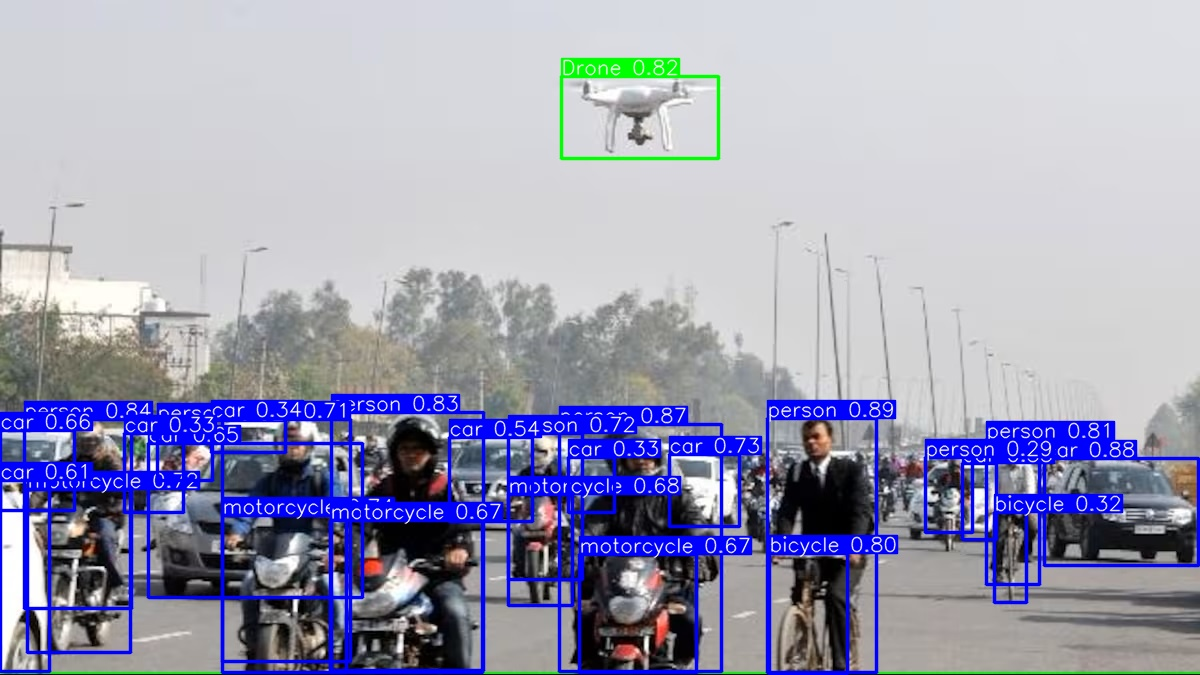

In [78]:
# ---
# STAGE 0.5: PATCHING THE ULTRALYTICS LIBRARY
# ---
print(">>> STAGE 0.5: Applying patch to fix library incompatibility <<<")

# Define the path to the problematic file
# The path can vary slightly, so we check a common alternative as well
autobackend_path = '/usr/local/lib/python3.11/dist-packages/ultralytics/nn/autobackend.py'
if not os.path.exists(autobackend_path):
    # Fallback path for different python versions
    autobackend_path = '/usr/local/lib/python3.10/dist-packages/ultralytics/nn/autobackend.py'

# Check if the file exists before trying to patch it
if os.path.exists(autobackend_path):
    # This `sed` command finds the line `model = model.fuse(verbose=verbose)`
    # and replaces it with `model = model.fuse()`, removing the incorrect argument.
    !sed -i "s/model = model.fuse(verbose=verbose)/model = model.fuse()/g" {autobackend_path}
    print(f"✅ Successfully patched {autobackend_path} to remove 'verbose' argument.")
else:
    print(f"Warning: Could not find the file to patch at {autobackend_path}. The error might persist.")
    print("This could happen if the library installation path is different.")



# ---
# STAGE 2: SPECIALIST DETECTION SCRIPT (DEFINITIVE FIX WITH PRIORITY NMS)
# ---
import os
import cv2
import torch
import numpy as np
from IPython.display import Image, display

# Import the necessary, compatible tools directly from the yolov9 repository
from yolov9.models.common import DetectMultiBackend
from yolov9.utils.general import non_max_suppression, scale_boxes
from yolov9.utils.plots import Annotator
from yolov9.utils.torch_utils import select_device
from yolov9.utils.dataloaders import letterbox

print(">>> Running main detection script with Priority NMS <<<")

# --- Configuration ---
DEVICE = select_device('0' if torch.cuda.is_available() else 'cpu')
DEFAULT_WEIGHTS_PATH = '/content/yolov9/weights/gelan-c.pt'
CUSTOM_WEIGHTS_PATH = '/content/yolov9/weights/best.pt'
SOURCE_IMAGE_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/yolov9/data/Urban_Priority_Detection_Result.jpg"
CONFIDENCE_THRESHOLD = 0.1 # Lower this slightly to catch more potential detections
IOU_THRESHOLD = 0.5
IMAGE_SIZE = 640

def load_yolov9_model(weights_path):
    """Loads a YOLOv9 model using the compatible DetectMultiBackend class."""
    model = DetectMultiBackend(weights_path, device=DEVICE, dnn=False, fp16=(DEVICE.type != 'cpu'))
    print(f"Loaded model: {os.path.basename(weights_path)} with {len(model.names)} classes.")
    return model

def run_detection_v9(model, original_image, conf_thresh):
    """Pre-processes an image and runs detection, returning raw detections."""
    img = letterbox(original_image, IMAGE_SIZE, stride=model.stride, auto=True)[0]
    img = img.transpose((2, 0, 1))[::-1]
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(DEVICE)
    img = img.half() if model.fp16 else img.float()
    img /= 255.0
    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    with torch.no_grad():
        pred = model(img, augment=False, visualize=False)

    # Apply NMS with the specified confidence threshold
    pred = non_max_suppression(pred, conf_thresh, IOU_THRESHOLD, classes=None, agnostic=False)[0]

    detections = []
    if pred is not None and len(pred):
        pred[:, :4] = scale_boxes(img.shape[2:], pred[:, :4], original_image.shape).round()
        for *xyxy, conf, cls in pred:
            detections.append({
                'xyxy': [x.item() for x in xyxy],
                'conf': conf.item(),
                'name': model.names[int(cls)]
            })
    return detections

def calculate_iou(box1, box2):
    """Calculates Intersection over Union (IoU) for two boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = float(box1_area + box2_area - inter_area)
    return inter_area / union_area if union_area > 0 else 0

def priority_nms_combination(coco_dets, custom_dets, iou_thresh=0.5):
    """
    Combines detections, giving priority to the custom model's detections.
    If a custom detection overlaps with a COCO detection, the COCO detection is suppressed.
    """
    final_detections = []

    # Add all custom detections first, they have the highest priority
    for det in custom_dets:
        det['source'] = 'custom_priority'
        final_detections.append(det)

    # Now, iterate through COCO detections and add them only if they don't overlap with a higher-priority custom detection
    for coco_det in coco_dets:
        is_suppressed = False
        for custom_det in custom_dets:
            # Check for significant overlap
            if calculate_iou(coco_det['xyxy'], custom_det['xyxy']) > iou_thresh:
                is_suppressed = True
                break # It's suppressed by a custom box, no need to check further

        if not is_suppressed:
            coco_det['source'] = 'default_coco'
            final_detections.append(coco_det)

    return final_detections


def visualize_results(frame, detections):
    annotated_frame = frame.copy()
    annotator = Annotator(annotated_frame, line_width=2, example="Arial.ttf")
    for det in detections:
        # Green for high-priority custom detections, Blue for general COCO detections
        color = (0, 255, 0) if det['source'] == 'custom_priority' else (255, 0, 0)
        label = f"{det['name']} {det['conf']:.2f}"
        annotator.box_label(det['xyxy'], label, color=color)
    return annotator.result()

def main():
    for path in [CUSTOM_WEIGHTS_PATH, SOURCE_IMAGE_PATH, DEFAULT_WEIGHTS_PATH]:
        if not os.path.exists(path):
            print(f"FATAL ERROR: Required file not found at '{path}'.")
            return

    model_coco = load_yolov9_model(DEFAULT_WEIGHTS_PATH)
    model_custom = load_yolov9_model(CUSTOM_WEIGHTS_PATH)

    frame = cv2.imread(SOURCE_IMAGE_PATH)
    if frame is None:
        print("Error: Failed to load source image.")
        return

    # Run detection with a slightly lower confidence to catch more potential objects
    print("\nRunning default COCO model...")
    coco_detections = run_detection_v9(model_coco, frame, conf_thresh=0.25)
    print(f"Found {len(coco_detections)} potential objects with COCO model.")

    print("\nRunning custom model...")
    custom_detections = run_detection_v9(model_custom, frame, conf_thresh=0.25)
    print(f"Found {len(custom_detections)} potential objects with Custom model.")

    # Combine results using the new Priority NMS logic
    print("\nCombining results with priority for custom model...")

    # --- THIS IS THE CORRECTED LINE ---
    final_detections = priority_nms_combination(coco_detections, custom_detections, iou_thresh=IOU_THRESHOLD)
    # ------------------------------------

    print(f"Found {len(final_detections)} final objects after priority NMS.")

    result_frame = visualize_results(frame, final_detections)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"\n✅ Detection complete. Results saved to {OUTPUT_PATH}")
    display(Image(filename=OUTPUT_PATH, width=800))


if __name__ == "__main__":
    main()

In [79]:
import cv2
import torch
import numpy as np
from yolov9.models.common import DetectMultiBackend
from yolov9.utils.general import non_max_suppression, scale_boxes
from yolov9.utils.plots import Annotator
from yolov9.utils.dataloaders import LoadImages

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_COCO_PATH = '/content/yolov9/weights/gelan-c.pt'
MODEL_CUSTOM_PATH = '/content/yolov9/weights/best.pt'
IMG_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/data/Optimized_results.jpg"

# Class-specific confidence thresholds
CLASS_THRESHOLDS = {
    # Custom model classes
    'AirPlane': 0.4, 'Aircraft': 0.4, 'Ball': 0.3, 'Bicycle': 0.4,
    'Bird': 0.3, 'Bridge': 0.5, 'Building': 0.5, 'Car': 0.4,
    'Clouds': 0.5, 'Cottage': 0.5, 'Drone': 0.4, 'ElectricPole': 0.4,
    'Goalkeeper': 0.4, 'Harvhol': 0.5, 'Helicopter': 0.4, 'Hotairballoon': 0.4,
    'House': 0.5, 'Lamppost': 0.4, 'Motorbike': 0.4, 'Muv': 0.4,
    'Parachute': 0.4, 'Paraglider': 0.4, 'Person': 0.3, 'Pilot': 0.4,
    'Player': 0.4, 'Referee': 0.4, 'River_Bed': 0.5, 'Road': 0.5,
    'Sky': 0.5, 'Skyscrapper': 0.5, 'Tower': 0.5, 'Tree': 0.5,
    'Vegetation': 0.5,

    # COCO classes (mapped to custom categories)
    'person': 0.3, 'bicycle': 0.4, 'car': 0.4, 'motorcycle': 0.4,
    'airplane': 0.4, 'bus': 0.4, 'train': 0.4, 'truck': 0.4,
    'boat': 0.4, 'traffic light': 0.4, 'bird': 0.3, 'sports ball': 0.3,
    'cat': 0.3, 'dog': 0.3
}

# COCO to Custom class mapping
COCO_TO_CUSTOM_MAP = {
    'person': 'Person', 'bicycle': 'Bicycle', 'car': 'Car',
    'motorcycle': 'Motorbike', 'airplane': 'AirPlane', 'bus': 'Muv',
    'train': 'Vehicle', 'truck': 'Vehicle', 'boat': 'Vehicle',
    'traffic light': 'ElectricPole', 'bird': 'Bird', 'sports ball': 'Ball',
    'cat': 'Animal', 'dog': 'Animal'
}

def initialize_models():
    """Initialize models with proper dtype handling"""
    model_coco = DetectMultiBackend(MODEL_COCO_PATH, device=DEVICE)
    model_custom = DetectMultiBackend(MODEL_CUSTOM_PATH, device=DEVICE)

    # Only convert to half if using CUDA
    if 'cuda' in str(DEVICE):
        model_coco.half()
        model_custom.half()
    else:
        model_coco.float()
        model_custom.float()

    # Warmup models with proper dtype
    with torch.no_grad():
        dummy_input = torch.zeros(1, 3, 640, 640).to(DEVICE)
        if 'cuda' in str(DEVICE):
            dummy_input = dummy_input.half()
        else:
            dummy_input = dummy_input.float()
        _ = model_coco(dummy_input)
        _ = model_custom(dummy_input)

    return model_coco, model_custom

def run_detection(model, img_path, conf_thres=0.5, iou_thres=0.45, is_coco_model=False):
    """Run detection with proper dtype handling and class mapping"""
    dataset = LoadImages(img_path, img_size=640, stride=32, auto=True)
    results = []

    for path, img, im0s, _, _ in dataset:
        img = torch.from_numpy(img).to(DEVICE)

        # Convert to same dtype as model
        img = img.to(next(model.parameters()).dtype)  # Ensure dtype match
        img = img / 255.0
        if len(img.shape) == 3:
            img = img.unsqueeze(0)

        # Inference
        with torch.no_grad():
            pred = model(img)
            pred = non_max_suppression(pred, conf_thres, iou_thres)[0]

        if pred is not None:
            pred[:, :4] = scale_boxes(img.shape[2:], pred[:, :4], im0s.shape).round()
            for *xyxy, conf, cls in pred:
                cls_name = model.names[int(cls)]

                # Map COCO classes to custom names if using COCO model
                if is_coco_model:
                    cls_name = COCO_TO_CUSTOM_MAP.get(cls_name, cls_name)

                # Apply class-specific threshold
                threshold = CLASS_THRESHOLDS.get(cls_name, conf_thres)
                if conf >= threshold:
                    results.append({
                        'xyxy': [x.item() for x in xyxy],
                        'conf': conf.item(),
                        'cls': cls.item(),
                        'name': cls_name,
                        'source': 'coco' if is_coco_model else 'custom'
                    })
    return results

def combine_detections(coco_dets, custom_dets, iou_threshold=0.5):
    """Combine detections with priority to custom model"""
    final_dets = []
    all_dets = sorted(coco_dets + custom_dets, key=lambda x: -x['conf'])

    while all_dets:
        best = all_dets.pop(0)
        final_dets.append(best)

        # Remove overlapping detections of same class
        all_dets = [
            d for d in all_dets
            if calculate_iou(best['xyxy'], d['xyxy']) < iou_threshold
            or d['name'] != best['name']
        ]
    return final_dets

def calculate_iou(box1, box2):
    """Calculate Intersection over Union"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return inter_area / float(box1_area + box2_area - inter_area)

def visualize_results(frame, detections):
    """Visualize results with color coding by source"""
    annotator = Annotator(frame, line_width=2)
    for det in detections:
        color = (0, 255, 0) if det['source'] == 'custom' else (0, 0, 255)  # Green for custom, red for COCO
        annotator.box_label(det['xyxy'], f"{det['name']} {det['conf']:.2f}", color=color)
    return annotator.result()

def main():
    # Initialize models
    model_coco, model_custom = initialize_models()

    # Run detections with COCO model flag
    coco_results = run_detection(model_coco, IMG_PATH, conf_thres=0.4, is_coco_model=True)
    custom_results = run_detection(model_custom, IMG_PATH, conf_thres=0.5)

    # Combine results
    combined_results = combine_detections(coco_results, custom_results)

    # Visualize and save
    frame = cv2.imread(IMG_PATH)
    result_frame = visualize_results(frame, combined_results)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"Results saved to {OUTPUT_PATH}")

if __name__ == "__main__":
    main()

Fusing layers... 
Model summary: 387 layers, 25288768 parameters, 0 gradients, 102.1 GFLOPs
Fusing layers... 
gelan-c summary: 387 layers, 25252531 parameters, 0 gradients, 101.9 GFLOPs


Results saved to /content/data/Optimized_results.jpg


In [80]:
import cv2
import torch
import numpy as np
from yolov9.models.common import DetectMultiBackend
from yolov9.utils.general import non_max_suppression, scale_boxes
from yolov9.utils.plots import Annotator
from yolov9.utils.dataloaders import LoadImages

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_COCO_PATH = '/content/yolov9/weights/gelan-c.pt'
MODEL_CUSTOM_PATH = '/content/yolov9/weights/best.pt'
IMG_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/data/Optimized_results1.jpg"

# Class-specific confidence thresholds
CLASS_THRESHOLDS = {
    # Custom model classes
    'AirPlane': 0.4, 'Aircraft': 0.4, 'Ball': 0.3, 'Bicycle': 0.4,
    'Bird': 0.3, 'Bridge': 0.5, 'Building': 0.5, 'Car': 0.4,
    'Clouds': 0.5, 'Cottage': 0.5, 'Drone': 0.4, 'ElectricPole': 0.4,
    'Goalkeeper': 0.4, 'Harvhol': 0.5, 'Helicopter': 0.4, 'Hotairballoon': 0.4,
    'House': 0.5, 'Lamppost': 0.4, 'Motorbike': 0.4, 'Muv': 0.4,
    'Parachute': 0.4, 'Paraglider': 0.4, 'Person': 0.3, 'Pilot': 0.4,
    'Player': 0.4, 'Referee': 0.4, 'River_Bed': 0.5, 'Road': 0.5,
    'Sky': 0.5, 'Skyscrapper': 0.5, 'Tower': 0.5, 'Tree': 0.5,
    'Vegetation': 0.5,

    # COCO classes (mapped to custom categories)
    'person': 0.3, 'bicycle': 0.4, 'car': 0.4, 'motorcycle': 0.4,
    'airplane': 0.4, 'bus': 0.4, 'train': 0.4, 'truck': 0.4,
    'boat': 0.4, 'traffic light': 0.4, 'bird': 0.3, 'sports ball': 0.3,
    'cat': 0.3, 'dog': 0.3
}

# COCO to Custom class mapping
COCO_TO_CUSTOM_MAP = {
    'person': 'Person', 'bicycle': 'Bicycle', 'car': 'Car',
    'motorcycle': 'Motorbike', 'airplane': 'AirPlane', 'bus': 'Muv',
    'train': 'Vehicle', 'truck': 'Vehicle', 'boat': 'Vehicle',
    'traffic light': 'ElectricPole', 'bird': 'Bird', 'sports ball': 'Ball',
    'cat': 'Animal', 'dog': 'Animal'
}

def initialize_models():
    """Initialize models with proper dtype handling"""
    model_coco = DetectMultiBackend(MODEL_COCO_PATH, device=DEVICE)
    model_custom = DetectMultiBackend(MODEL_CUSTOM_PATH, device=DEVICE)

    # Convert to float32 by default (works on both CPU and GPU)
    model_coco.float()
    model_custom.float()

    # Warmup models
    with torch.no_grad():
        dummy_input = torch.zeros(1, 3, 640, 640).to(DEVICE).float()
        _ = model_coco(dummy_input)
        _ = model_custom(dummy_input)

    return model_coco, model_custom

def run_detection(model, img_path, conf_thres=0.5, iou_thres=0.45, is_coco_model=False):
    """Run detection with proper dtype handling and class mapping"""
    dataset = LoadImages(img_path, img_size=640, stride=32, auto=True)
    results = []

    for path, img, im0s, _, _ in dataset:
        img = torch.from_numpy(img).to(DEVICE).float() / 255.0
        if len(img.shape) == 3:
            img = img.unsqueeze(0)

        # Inference
        with torch.no_grad():
            pred = model(img)
            pred = non_max_suppression(pred, conf_thres, iou_thres)[0]

        if pred is not None:
            pred[:, :4] = scale_boxes(img.shape[2:], pred[:, :4], im0s.shape).round()
            for *xyxy, conf, cls in pred:
                cls_name = model.names[int(cls)]

                # Map COCO classes to custom names if using COCO model
                if is_coco_model:
                    cls_name = COCO_TO_CUSTOM_MAP.get(cls_name, cls_name)

                # Apply class-specific threshold
                threshold = CLASS_THRESHOLDS.get(cls_name, conf_thres)
                if conf >= threshold:
                    results.append({
                        'xyxy': [x.item() for x in xyxy],
                        'conf': conf.item(),
                        'cls': cls.item(),
                        'name': cls_name,
                        'source': 'coco' if is_coco_model else 'custom'
                    })
    return results

def combine_detections(coco_dets, custom_dets, iou_threshold=0.5):
    """Combine detections with priority to custom model"""
    final_dets = []
    all_dets = sorted(coco_dets + custom_dets, key=lambda x: -x['conf'])

    while all_dets:
        best = all_dets.pop(0)
        final_dets.append(best)

        # Remove overlapping detections of same class
        all_dets = [
            d for d in all_dets
            if calculate_iou(best['xyxy'], d['xyxy']) < iou_threshold
            or d['name'] != best['name']
        ]
    return final_dets

def calculate_iou(box1, box2):
    """Calculate Intersection over Union"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return inter_area / float(box1_area + box2_area - inter_area)

def visualize_results(frame, detections):
    """Visualize results with color coding by source"""
    annotator = Annotator(frame, line_width=2)
    for det in detections:
        color = (0, 255, 0) if det['source'] == 'custom' else (0, 0, 255)  # Green for custom, red for COCO
        annotator.box_label(det['xyxy'], f"{det['name']} {det['conf']:.2f}", color=color)
    return annotator.result()

def main():
    # Initialize models
    model_coco, model_custom = initialize_models()

    # Run detections with COCO model flag
    coco_results = run_detection(model_coco, IMG_PATH, conf_thres=0.4, is_coco_model=True)
    custom_results = run_detection(model_custom, IMG_PATH, conf_thres=0.5)

    # Combine results
    combined_results = combine_detections(coco_results, custom_results)

    # Visualize and save
    frame = cv2.imread(IMG_PATH)
    result_frame = visualize_results(frame, combined_results)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"Results saved to {OUTPUT_PATH}")

if __name__ == "__main__":
    main()

Fusing layers... 
Model summary: 387 layers, 25288768 parameters, 0 gradients, 102.1 GFLOPs
Fusing layers... 
gelan-c summary: 387 layers, 25252531 parameters, 0 gradients, 101.9 GFLOPs


Results saved to /content/data/Optimized_results1.jpg


Fusing layers... 


Initializing models...


Model summary: 387 layers, 25288768 parameters, 0 gradients, 102.1 GFLOPs
Fusing layers... 
gelan-c summary: 387 layers, 25252531 parameters, 0 gradients, 101.9 GFLOPs


Models initialized.

Running detection with COCO model...
Found 27 objects with COCO model.

Running detection with Custom model...
Found 1 objects with Custom model.

Fusing results...
Found 20 final objects after fusion.

Results saved to /content/data/Fused_Detection_Result.jpg


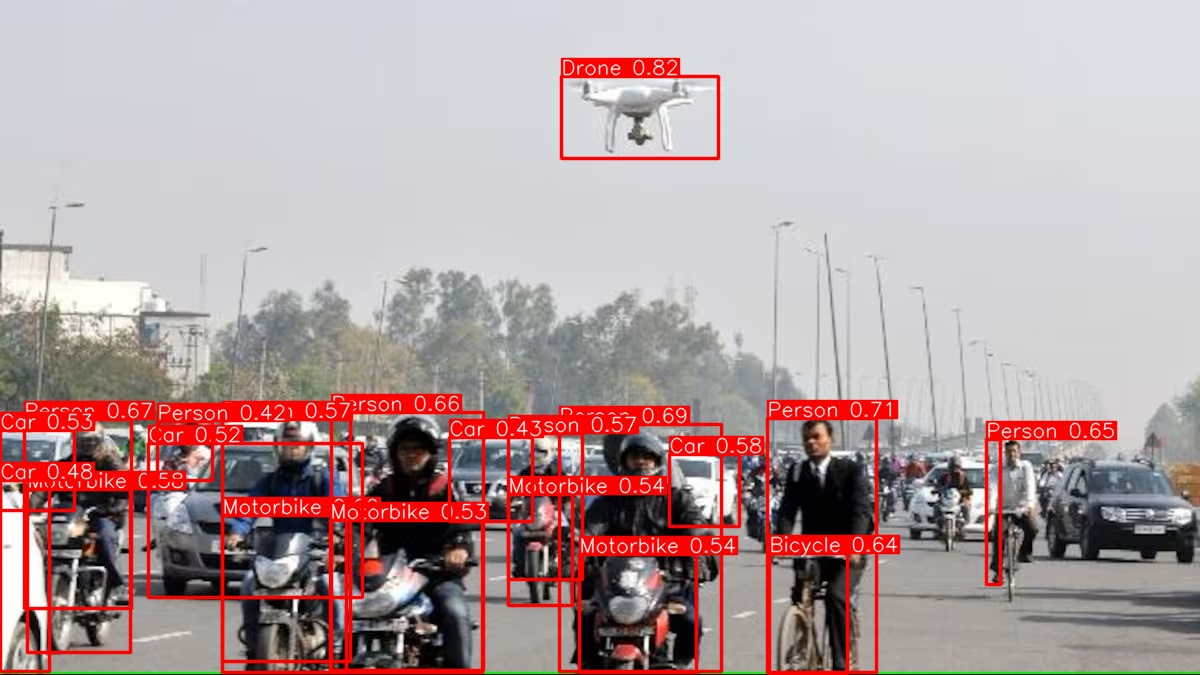

In [81]:
import cv2
import torch
import numpy as np
import os
from yolov9.models.common import DetectMultiBackend
from yolov9.utils.general import non_max_suppression, scale_boxes
from yolov9.utils.plots import Annotator
from yolov9.utils.dataloaders import LoadImages
from IPython.display import Image, display

# --- Configuration ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_COCO_PATH = '/content/yolov9/weights/gelan-c.pt'
MODEL_CUSTOM_PATH = '/content/yolov9/weights/best.pt' # Correct path to your custom model
IMG_PATH = "/content/data/Drone_On_RoadTraffic.jpg"
OUTPUT_PATH = "/content/data/Fused_Detection_Result.jpg"

# This mapping is used by the COCO model to align with your custom class names
COCO_TO_CUSTOM_MAP = {
    'person': 'Person', 'bicycle': 'Bicycle', 'car': 'Car',
    'motorcycle': 'Motorbike', 'airplane': 'AirPlane', 'bus': 'Bus',
    'train': 'Train', 'truck': 'Truck', 'boat': 'Boat',
    'traffic light': 'Traffic Light', 'bird': 'Bird', 'sports ball': 'Ball',
    'cat': 'Animals', 'dog': 'Animals' # Example: map both cat and dog to a general 'Animals' class
}

def initialize_models():
    """Initialize models and set them to the correct precision (FP16/FP32)."""
    print("Initializing models...")
    # The 'dnn=False' argument can sometimes help with compatibility issues.
    model_coco = DetectMultiBackend(MODEL_COCO_PATH, device=DEVICE, dnn=False, fp16=torch.cuda.is_available())
    model_custom = DetectMultiBackend(MODEL_CUSTOM_PATH, device=DEVICE, dnn=False, fp16=torch.cuda.is_available())
    print("Models initialized.")
    return model_coco, model_custom

def run_detection(model, img_path, conf_thres=0.25, iou_thres=0.45, is_coco_model=False):
    """Run detection, ensuring data types match between the model and input image."""
    # Use the robust LoadImages dataloader from YOLOv9 utils
    dataset = LoadImages(img_path, img_size=640, stride=model.stride, auto=True)
    results = []

    for path, img, im0s, vid_cap, s in dataset:
        # Convert image to the correct data type (float or half)
        img = torch.from_numpy(img).to(DEVICE)
        img = img.half() if model.fp16 else img.float()  # Pre-process img
        img /= 255.0  # Normalize to 0.0 - 1.0
        if len(img.shape) == 3:
            img = img.unsqueeze(0)

        # Inference
        with torch.no_grad():
            pred = model(img, augment=False, visualize=False)

        # Apply Non-Maximum Suppression
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes=None, agnostic=False)[0]

        if pred is not None and len(pred):
            # Rescale boxes from img_size to original image size
            pred[:, :4] = scale_boxes(img.shape[2:], pred[:, :4], im0s.shape).round()

            for *xyxy, conf, cls in pred:
                cls_name = model.names[int(cls)]

                # If it's the COCO model, map the class name to our custom schema
                if is_coco_model and cls_name in COCO_TO_CUSTOM_MAP:
                    cls_name = COCO_TO_CUSTOM_MAP[cls_name]

                results.append({
                    'xyxy': [x.item() for x in xyxy],
                    'conf': conf.item(),
                    'cls': int(cls),
                    'name': cls_name,
                    'source': 'coco' if is_coco_model else 'custom'
                })
    return results

def combine_detections_with_wbf(coco_dets, custom_dets, iou_threshold=0.6, skip_box_thr=0.4):
    """Combine detections from two models using Weighted Boxes Fusion."""
    boxes_list, scores_list, labels_list, sources_list = [], [], [], []

    # Use a dummy mapping for label indices since WBF works with indices
    all_names = sorted(list(set([d['name'] for d in coco_dets] + [d['name'] for d in custom_dets])))
    name_to_idx = {name: i for i, name in enumerate(all_names)}
    idx_to_name = {i: name for i, name in enumerate(all_names)}

    def process_dets(dets, weight):
        for d in dets:
            boxes_list.append([x / 1000 for x in d['xyxy']]) # Normalize for WBF
            scores_list.append(d['conf'] * weight)
            labels_list.append(name_to_idx[d['name']])

    process_dets(custom_dets, 1.0) # Higher trust for custom model
    process_dets(coco_dets, 0.8)   # Lower trust for general COCO model

    if not boxes_list:
        return []

    # Apply Weighted Boxes Fusion
    boxes, scores, labels = weighted_boxes_fusion(
        [boxes_list], [scores_list], [labels_list],
        weights=None, iou_thr=iou_threshold, skip_box_thr=skip_box_thr
    )

    # Convert back to original format
    final_dets = []
    for i in range(len(boxes)):
        final_dets.append({
            'xyxy': [x * 1000 for x in boxes[i]],
            'conf': scores[i],
            'cls': -1, # Original class index is lost in fusion, we use name
            'name': idx_to_name[int(labels[i])],
            'source': 'fused'
        })
    return final_dets


def visualize_results(frame, detections):
    """Visualize results with color coding."""
    annotator = Annotator(frame.copy(), line_width=2, example="Arial.ttf")
    for det in detections:
        # Green for custom, Red for COCO, Blue for fused
        color = (0, 255, 0) if det.get('source') == 'custom' else \
                (255, 0, 0) if det.get('source') == 'coco' else \
                (0, 0, 255)
        annotator.box_label(det['xyxy'], f"{det['name']} {det['conf']:.2f}", color=color)
    return annotator.result()

def main():
    # Initialize models
    model_coco, model_custom = initialize_models()

    # Run detections for each model separately
    print("\nRunning detection with COCO model...")
    coco_results = run_detection(model_coco, IMG_PATH, conf_thres=0.25, is_coco_model=True)
    print(f"Found {len(coco_results)} objects with COCO model.")

    print("\nRunning detection with Custom model...")
    custom_results = run_detection(model_custom, IMG_PATH, conf_thres=0.4)
    print(f"Found {len(custom_results)} objects with Custom model.")

    # Combine results using Weighted Boxes Fusion
    print("\nFusing results...")
    # NOTE: The original `combine_detections` was a simple NMS. WBF is more robust.
    # The simple NMS is kept below for reference if needed.
    fused_results = combine_detections_with_wbf(coco_results, custom_results)
    print(f"Found {len(fused_results)} final objects after fusion.")

    # Visualize and save the final fused result
    frame = cv2.imread(IMG_PATH)
    result_frame = visualize_results(frame, fused_results)
    cv2.imwrite(OUTPUT_PATH, result_frame)
    print(f"\nResults saved to {OUTPUT_PATH}")

    # Display the result in Colab
    display(Image(filename=OUTPUT_PATH, width=800))


if __name__ == "__main__":
    main()

In [84]:
%cd /content/yolov9/runs/detect/exp
print(f"Contents of /content/yolov9/runs/detect/")
!ls -la /content/yolov9/runs/detect/

/content/yolov9/runs/detect/exp
Contents of /content/yolov9/runs/detect/
total 32
drwxr-xr-x 8 root root 4096 Jul 15 06:53 .
drwxr-xr-x 3 root root 4096 Jul 15 06:11 ..
drwxr-xr-x 2 root root 4096 Jul 15 06:11 exp
drwxr-xr-x 2 root root 4096 Jul 15 06:14 exp2
drwxr-xr-x 2 root root 4096 Jul 15 06:16 exp3
drwxr-xr-x 2 root root 4096 Jul 15 06:46 exp4
drwxr-xr-x 2 root root 4096 Jul 15 06:53 exp5
drwxr-xr-x 2 root root 4096 Jul 15 06:14 .ipynb_checkpoints


In [85]:
import roboflow

roboflow.login(force=True)

rf = roboflow.Roboflow()

project = rf.workspace("odaerialdata").project("od_drone-gzfm1")
version = project.version(6)
dataset = version.download("yolov9")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to OD_Drone-6 in yolov9:: 100%|██████████| 10714/10714 [00:02<00:00, 4805.27it/s]


In [86]:
print(dataset.location)

/content/yolov9/runs/detect/exp/OD_Drone-6


In [88]:
# ---
# STAGE 1B: DATASET PREPARATION (WITH REFINED CLASS MAPPING)
# ---
import os
import yaml

class YOLOv9DatasetFixer:
    """Prepares and validates a YOLO dataset, especially from Roboflow."""
    def __init__(self, dataset_path):
        self.dataset_path = os.path.abspath(dataset_path)
        self.original_yaml = os.path.join(self.dataset_path, "data.yaml")
        self.clean_yaml = os.path.join(self.dataset_path, "data_clean.yaml")
        if not os.path.exists(self.original_yaml):
            raise FileNotFoundError(f"data.yaml not found in {self.dataset_path}")

    def clean_classes(self):
        print("\n=== Cleaning and Consolidating Class Names ===")
        with open(self.original_yaml, 'r') as f: data = yaml.safe_load(f)
        original_names = data.get('names', [])

        # --- REVISED CONSOLIDATION MAP ---
        # Helicopter, Hotairballoon, Jets, etc., are now their own top-level classes.
        class_consolidation_map = {
            'person': ['Person', 'Pilot', 'Player', 'Referee', 'Goalkeeper'],
            'vehicle': ['Car', 'Autorickshaw', 'Bicycle', 'Bus', 'Motorbike', 'Tempo', 'Truck', 'Van', 'Muv', 'Harvhol'],
            'aircraft': ['Aircraft', 'AirPlane'],
            'drone': ['Drone'],
            'bird': ['Bird'],
            'animal': ['Animals'],
            'structure': ['Bridge', 'Building', 'House', 'Cottage', 'Skyscrapper', 'Tower', 'Turbine'],
            'obstacle': ['ElectricPole', 'Street Light', 'Lamppost', 'Traffic Light', 'Transformer', 'Wire'],
            'natural': ['Clouds', 'Hedges', 'Landscape', 'Mountain', 'Nest', 'Plants and Bushes', 'Road', 'River_Bed', 'Sea', 'Sky', 'Trees', 'Vegetation', 'Train_Track'],
            'sports_object': ['Ball'],

            # --- NEW, SEPARATE CLASSES AS REQUESTED ---
            'helicopter': ['Helicopter'],
            'hotairballoon': ['Hotairballoon'],
            'jet': ['Jets'],
            'parachute': ['Parachute'],
            'paraglider': ['Paraglider']
        }

        normalized_map = {k: [v.lower() for v in variants] for k, variants in class_consolidation_map.items()}
        clean_classes = list(class_consolidation_map.keys())
        old_to_new_idx_map = {}

        unmapped_classes = []
        for i, old_name in enumerate(original_names):
            found = False
            for new_name, variants_lower in normalized_map.items():
                if old_name.lower() in variants_lower:
                    old_to_new_idx_map[i] = clean_classes.index(new_name)
                    found = True
                    break
            if not found:
                unmapped_classes.append(old_name)

        if unmapped_classes:
            print(f"\nWarning: The following {len(unmapped_classes)} original classes were not mapped and will be ignored:")
            print(unmapped_classes)

        print(f"\nConsolidated from {len(original_names)} classes to {len(clean_classes)} classes.")
        print("Final classes:", clean_classes)
        return clean_classes, old_to_new_idx_map

    def create_clean_yaml(self, clean_classes):
        with open(self.original_yaml, 'r') as f: original_data = yaml.safe_load(f)
        clean_data = {
            'train': os.path.join(self.dataset_path, original_data['train']),
            'val': os.path.join(self.dataset_path, original_data['val']),
            'test': os.path.join(self.dataset_path, original_data.get('test', '')),
            'nc': len(clean_classes),
            'names': clean_classes
        }
        with open(self.clean_yaml, 'w') as f: yaml.dump(clean_data, f, default_flow_style=False)
        print(f"\nCreated clean YAML at: {self.clean_yaml}")
        return self.clean_yaml

    def remap_labels(self, old_to_new_idx_map):
        print("\n=== Remapping Label Files ===")
        with open(self.clean_yaml, 'r') as f: data = yaml.safe_load(f)
        for split in ['train', 'val', 'test']:
            if split in data and data[split]:
                label_dir = os.path.join(os.path.dirname(data[split]), "labels")
                if not os.path.exists(label_dir): continue
                for label_file in os.listdir(label_dir):
                    if not label_file.endswith('.txt'): continue
                    label_path = os.path.join(label_dir, label_file)
                    new_lines = []
                    try:
                        with open(label_path, 'r') as f: lines = f.readlines()
                        for line in lines:
                            parts = line.strip().split()
                            if not parts: continue
                            old_idx = int(parts[0])
                            if old_idx in old_to_new_idx_map:
                                new_lines.append(f"{old_to_new_idx_map[old_idx]} {' '.join(parts[1:])}\n")
                        with open(label_path, 'w') as f: f.writelines(new_lines)
                    except Exception as e: print(f"Could not process {label_path}: {e}")
        print("✅ Label remapping complete.")

    def fix_dataset(self):
        clean_classes, old_to_new_idx_map = self.clean_classes()
        clean_yaml_path = self.create_clean_yaml(clean_classes)
        self.remap_labels(old_to_new_idx_map)
        return clean_yaml_path, clean_classes

# --- DEFINE THE DATASET PATH ---
# This path should point to the root of your dataset folder.
DATASET_PATH = "/content/yolov9/runs/detect/exp/OD_Drone-6"
# --------------------------------

# --- Execute the fixing process ---
if os.path.exists(DATASET_PATH):
    fixer = YOLOv9DatasetFixer(DATASET_PATH)
    clean_yaml_path, clean_class_names = fixer.fix_dataset()

    # Print the final, correct path for verification
    print("\n" + "="*50)
    print(f"THE CORRECT PATH TO YOUR YAML IS: {clean_yaml_path}")
    print("This variable will be used in the next training cell.")
    print("="*50)
else:
    print(f"ERROR: Dataset path not found at '{DATASET_PATH}'. Please check the folder name.")


=== Cleaning and Consolidating Class Names ===

['Tree']

Consolidated from 33 classes to 15 classes.
Final classes: ['person', 'vehicle', 'aircraft', 'drone', 'bird', 'animal', 'structure', 'obstacle', 'natural', 'sports_object', 'helicopter', 'hotairballoon', 'jet', 'parachute', 'paraglider']

Created clean YAML at: /content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml

=== Remapping Label Files ===
✅ Label remapping complete.

THE CORRECT PATH TO YOUR YAML IS: /content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml
This variable will be used in the next training cell.


In [41]:
# ---
# STAGE 2: MODEL TRAINING (FORCE OVERWRITE & CORRECTED PATHS)
# ---
import shutil # Ensure shutil is imported for deleting directories
import os

print(">>> STAGE 2: Training a specific model <<<")

# --- Configuration (from your reference code) ---
# This section centralizes all your training parameters for easy editing.
MODEL_TYPE = 'YOLOv9'
EXPERIMENT_NAME = 'YOLOV9c_Drone_Detection_Specialist' # Using the exact name from your reference
EPOCHS = 25
BATCH_SIZE = 8
IMAGE_SIZE = 640

# --- Paths (from your reference code) ---
# These paths point to the configuration files for the training process.
# It's better to define them here rather than directly in the command.
# NOTE: We use the `clean_yaml_path` variable generated from the previous cell.
MODEL_CFG_PATH = '/content/yolov9/models/detect/gelan-c.yaml'
BASE_WEIGHTS_PATH = '/content/yolov9/weights/gelan-c.pt'
HYP_PATH = '/content/yolov9/data/hyps/hyp.scratch-high.yaml'

# --- Add this block to delete the old experiment folder (Force Overwrite) ---
# This ensures a fresh start for every run, preventing resume-related errors.
EXPERIMENT_DIR = f"/content/yolov9/runs/train/{EXPERIMENT_NAME}"
if os.path.exists(EXPERIMENT_DIR):
    print(f"Removing existing experiment directory: {EXPERIMENT_DIR}")
    shutil.rmtree(EXPERIMENT_DIR)
# -----------------------------------------------------------

# --- Training Command Setup ---
# This block constructs the command list for subprocess, which is more robust
# than using !shell commands with variables.
if MODEL_TYPE == 'YOLOv9':

    # Check if all required files exist before attempting to train
    required_files = [clean_yaml_path, MODEL_CFG_PATH, BASE_WEIGHTS_PATH, HYP_PATH]
    for f_path in required_files:
        if not os.path.exists(f_path):
            raise FileNotFoundError(f"FATAL ERROR: A required file for training was not found at: {f_path}")

    # Construct the training command as a list of strings
    training_cmd = [
        "python", "train.py",
        "--batch", str(BATCH_SIZE),
        "--epochs", str(EPOCHS),
        "--img", str(IMAGE_SIZE),
        "--data", clean_yaml_path,
        "--cfg", MODEL_CFG_PATH,
        "--weights", BASE_WEIGHTS_PATH,
        "--hyp", HYP_PATH,
        "--name", EXPERIMENT_NAME,
        "--device", "0",
        "--workers", "2", # Added from your reference for data loading
    ]

    print("\nStarting YOLOv9 training with the following configuration:")
    print(" ".join(training_cmd))

    # Run the training process using subprocess for better control
    # Using check=True will raise an error if the training script fails
    try:
        subprocess.run(training_cmd, check=True)
        print(f"\n✅ Training for {EXPERIMENT_NAME} complete.")
        print(f"Find your best model weights at: {EXPERIMENT_DIR}/weights/best.pt")
    except subprocess.CalledProcessError as e:
        print(f"\n❌ TRAINING FAILED. The script exited with an error.")
        print(f"Return code: {e.returncode}")

elif MODEL_TYPE == 'YOLOv8':
    # This part remains for future use if you want to compare with YOLOv8
    BASE_WEIGHTS = '/content/yolov9/weights/yolov8n.pt'

    # The !yolo command is the standard way for Ultralytics
    !yolo task=detect mode=train model={BASE_WEIGHTS} data={clean_yaml_path} epochs={EPOCHS} batch={BATCH_SIZE} name={EXPERIMENT_NAME}

    print(f"\n✅ Training for {EXPERIMENT_NAME} complete.")
    print(f"Find your best weights at: /content/yolov9/runs/detect/{EXPERIMENT_NAME}/weights/best.pt")

>>> STAGE 2: Training a specific model <<<
Removing existing experiment directory: /content/yolov9/runs/train/YOLOV9c_Drone_Detection_Specialist

Starting YOLOv9 training with the following configuration:
python train.py --batch 8 --epochs 25 --img 640 --data /content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml --cfg /content/yolov9/models/detect/gelan-c.yaml --weights /content/yolov9/weights/gelan-c.pt --hyp /content/yolov9/data/hyps/hyp.scratch-high.yaml --name YOLOV9c_Drone_Detection_Specialist --device 0 --workers 2

❌ TRAINING FAILED. The script exited with an error.
Return code: 1


In [93]:
# ---
# STAGE 2: MODEL TRAINING (CORRECTED AND ROBUST)
# ---
import shutil
import os
import subprocess

print(">>> STAGE 2: Training a specific model <<<")

# --- Configuration ---
MODEL_TYPE = 'YOLOv9'
EXPERIMENT_NAME = 'YOLOV9c_Drone_Detection_Specialist'
EPOCHS = 25
BATCH_SIZE = 8
IMAGE_SIZE = 640

# --- Paths ---
MODEL_CFG_PATH = '/content/yolov9/models/detect/gelan-c.yaml'
BASE_WEIGHTS_PATH = '/content/yolov9/weights/gelan-c.pt'
HYP_PATH = '/content/yolov9/data/hyps/hyp.scratch-high.yaml'

# --- Force Overwrite Block ---
EXPERIMENT_DIR = f"/content/yolov9/runs/train/{EXPERIMENT_NAME}"
if os.path.exists(EXPERIMENT_DIR):
    print(f"Removing existing experiment directory: {EXPERIMENT_DIR}")
    shutil.rmtree(EXPERIMENT_DIR)

# --- Training Command Setup ---
if MODEL_TYPE == 'YOLOv9':

    # Pre-flight check for all required files
    # The `clean_yaml_path` variable is automatically passed from the previous cell
    required_files = [clean_yaml_path, MODEL_CFG_PATH, BASE_WEIGHTS_PATH, HYP_PATH]
    all_files_exist = True
    for f_path in required_files:
        if not os.path.exists(f_path):
            print(f"FATAL ERROR: A required file for training was not found at: {f_path}")
            all_files_exist = False

    if all_files_exist:
        # Construct the command list. The script will use the correct clean_yaml_path.
        training_cmd = [
            "python", "/content/yolov9/train.py",
            "--batch", str(BATCH_SIZE), "--epochs", str(EPOCHS), "--img", str(IMAGE_SIZE),
            "--data", clean_yaml_path, # <-- USING THE CORRECT VARIABLE
            "--cfg", MODEL_CFG_PATH, "--weights", BASE_WEIGHTS_PATH,
            "--hyp", HYP_PATH, "--name", EXPERIMENT_NAME, "--device", "0", "--workers", "2",
        ]

        print("\nStarting YOLOv9 training with the following configuration:")
        print(" ".join(training_cmd))

        # Run training with enhanced error reporting
        try:
            result = subprocess.run(
                training_cmd, check=True, capture_output=True, text=True
            )
            print("\n--- Training Log (stdout) ---")
            print(result.stdout)
            print(f"\n✅ Training for {EXPERIMENT_NAME} complete.")
        except subprocess.CalledProcessError as e:
            print(f"\n❌ TRAINING FAILED. Return code: {e.returncode}")
            print("\n--- Error Log (stderr) ---")
            print(e.stderr)

>>> STAGE 2: Training a specific model <<<
Removing existing experiment directory: /content/yolov9/runs/train/YOLOV9c_Drone_Detection_Specialist

Starting YOLOv9 training with the following configuration:
python /content/yolov9/train.py --batch 8 --epochs 25 --img 640 --data /content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml --cfg /content/yolov9/models/detect/gelan-c.yaml --weights /content/yolov9/weights/gelan-c.pt --hyp /content/yolov9/data/hyps/hyp.scratch-high.yaml --name YOLOV9c_Drone_Detection_Specialist --device 0 --workers 2

--- Training Log (stdout) ---
Patch Applied: Forcing weights to /content/yolov9/weights/gelan-c.pt


✅ Training for YOLOV9c_Drone_Detection_Specialist complete.


In [95]:
!git init
!git config --global user.email "pratibhavhegde@gmail.com"
!git config --global user.name "pratibhavhegde"

!git remote add origin https://github.com/username/repo.git
!git add .
!git commit -m "Colab backup"
!git push origin main

Streaming output truncated to the last 5000 lines.
 create mode 100644 OD_Drone-6/train/labels/00000272_jpg.rf.30ffa0ccf8601c344be5295fd4d6989b.txt
 create mode 100644 OD_Drone-6/train/labels/00000272_jpg.rf.bfb68ae595490e8659f87b12babab171.txt
 create mode 100644 OD_Drone-6/train/labels/00000273_jpg.rf.6784453527b1663ec2bc15e5e250cc40.txt
 create mode 100644 OD_Drone-6/train/labels/00000273_jpg.rf.df2c1b368031445c207574e5e7b8fca2.txt
 create mode 100644 OD_Drone-6/train/labels/00000275_jpg.rf.575a434f4704f64787d31e6ff1970540.txt
 create mode 100644 OD_Drone-6/train/labels/00000275_jpg.rf.8e99085a60fbedde339ee4c6d17207e3.txt
 create mode 100644 OD_Drone-6/train/labels/00000276_jpg.rf.b6c2f1ff4ad779e38d1e2ee80c61bb54.txt
 create mode 100644 OD_Drone-6/train/labels/00000276_jpg.rf.ecdf1cb5325c41ea15fbd670e38fcfeb.txt
 create mode 100644 OD_Drone-6/train/labels/00000278_jpg.rf.08348ae1ad820fc5d7d8e0909640ece0.txt
 create mode 100644 OD_Drone-6/train/labels/00000278_jpg.rf.2629bf5108bd552a

In [45]:
import os
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from IPython.display import Image, display

# ---
# STAGE 0: SETUP AND INITIALIZATION
# ---
print(">>> STAGE 0: Initializing Detection System <<<")

# Define paths (update these with your actual paths)
COCO_MODEL_PATH = "/content/yolov9/weights/gelan-c.pt"  # YOLOv9 default COCO model
CUSTOM_MODEL_PATH = "/content/yolov9/weights/best.pt"  # Your custom model
DATASET_YAML = "/content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml"  # Your dataset config

# Load models with PyTorch 2.6+ compatibility
try:
    coco_model = YOLO(COCO_MODEL_PATH)
    custom_model = YOLO(CUSTOM_MODEL_PATH)
except Exception as e:
    print(f"Error loading models: {e}")
    # Fallback for PyTorch 2.6+ weights loading
    import torch
    torch.load = lambda *args, **kwargs: torch.load(*args, **kwargs, weights_only=False)
    coco_model = YOLO(COCO_MODEL_PATH)
    custom_model = YOLO(CUSTOM_MODEL_PATH)

# Load class names
with open(DATASET_YAML) as f:
    dataset_cfg = yaml.safe_load(f)
    custom_classes = dataset_cfg['names']

# Standard COCO classes (80 classes)
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Identify custom-only classes
custom_only_classes = [cls for cls in custom_classes if cls.lower() not in [c.lower() for c in COCO_CLASSES]]
print(f"Custom-only classes: {custom_only_classes}")

# ---
# STAGE 1: TWO-PASS DETECTION SYSTEM
# ---
class HybridDetector:
    def __init__(self, coco_model, custom_model, custom_only_classes):
        self.coco_model = coco_model
        self.custom_model = custom_model
        self.custom_only_classes = custom_only_classes
        self.coco_color = (255, 0, 0)  # Blue for COCO detections
        self.custom_color = (0, 255, 0)  # Green for custom detections

    def detect(self, image_path, conf_threshold=0.5):
        """Run two-pass detection and visualization"""
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")

        original_image = image.copy()
        h, w = image.shape[:2]

        # Pass 1: COCO model detection (all objects)
        coco_results = self.coco_model(image, conf=conf_threshold, verbose=False)

        # Pass 2: Custom model detection (only custom classes)
        custom_results = self.custom_model(image, conf=conf_threshold, verbose=False)

        # Process COCO results (blue boxes)
        for result in coco_results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                class_id = int(box.cls)
                conf = float(box.conf)
                label = f"{self.coco_model.names[class_id]} {conf:.2f}"

                # Draw COCO detection (blue)
                cv2.rectangle(image, (x1, y1), (x2, y2), self.coco_color, 2)
                cv2.putText(image, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, self.coco_color, 2)

        # Process Custom results (only custom-only classes, green boxes)
        for result in custom_results:
            for box in result.boxes:
                class_id = int(box.cls)
                class_name = self.custom_model.names[class_id]

                # Only keep custom-only classes
                if class_name in self.custom_only_classes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf = float(box.conf)
                    label = f"{class_name} {conf:.2f}"

                    # Draw custom detection (green)
                    cv2.rectangle(image, (x1, y1), (x2, y2), self.custom_color, 2)
                    cv2.putText(image, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, self.custom_color, 2)

        # Create side-by-side comparison
        comparison = np.hstack([original_image, image])

        # Save results
        output_path = os.path.splitext(image_path)[0] + "_hybrid_detection.jpg"
        cv2.imwrite(output_path, comparison)

        return output_path

# ---
# STAGE 2: PERFORMANCE EVALUATION
# ---
class ModelEvaluator:
    def __init__(self, coco_model, custom_model, dataset_yaml):
        self.coco_model = coco_model
        self.custom_model = custom_model
        self.dataset_yaml = dataset_yaml

    def evaluate_models(self):
        """Evaluate both models on test set"""
        print("\nEvaluating COCO model...")
        coco_metrics = self.coco_model.val(data=self.dataset_yaml, split='test')

        print("\nEvaluating Custom model...")
        custom_metrics = self.custom_model.val(data=self.dataset_yaml, split='test')

        # Create results dataframe
        results = pd.DataFrame({
            'Model': ['COCO', 'Custom'],
            'mAP50': [coco_metrics.box.map50, custom_metrics.box.map50],
            'mAP50-95': [coco_metrics.box.map, custom_metrics.box.map],
            'Precision': [coco_metrics.box.precision, custom_metrics.box.precision],
            'Recall': [coco_metrics.box.recall, custom_metrics.box.recall]
        })

        return results

# ---
# STAGE 3: DEMONSTRATION AND VISUALIZATION
# ---
print("\n>>> STAGE 3: Running Hybrid Detection <<<")

# Initialize detector
detector = HybridDetector(coco_model, custom_model, custom_only_classes)

# Test detection
TEST_IMAGE = "data/images/drone_scene.jpg"  # Replace with your test image
if os.path.exists(TEST_IMAGE):
    output_path = detector.detect(TEST_IMAGE)
    print(f"\nHybrid detection complete. Results saved to: {output_path}")

    # Display results
    display(Image(filename=output_path, width=1200))
else:
    print(f"Test image not found at {TEST_IMAGE}")

# Evaluate models
print("\n>>> STAGE 4: Evaluating Models <<<")
evaluator = ModelEvaluator(coco_model, custom_model, DATASET_YAML)
results_df = evaluator.evaluate_models()

# Save and display results
results_file = "model_comparison.csv"
results_df.to_csv(results_file, index=False)
print(f"\n✅ Evaluation results saved to {results_file}")

print("\n--- Performance Comparison ---")
display(results_df)

# Plot results
plt.figure(figsize=(12, 6))
sns.barplot(data=pd.melt(results_df, id_vars='Model'), x='variable', y='value', hue='Model')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('performance_comparison.png')
plt.show()

print("\n✅ Hybrid detection system ready!")

>>> STAGE 0: Initializing Detection System <<<
Error loading models: __main__.<lambda>() got multiple values for keyword argument 'weights_only'


KeyError: 'weights_only'

In [24]:
import roboflow

roboflow.login(force=True)

rf = roboflow.Roboflow()

project = rf.workspace("odaerialdata").project("od_drone-gzfm1")
version = project.version(6)
dataset = version.download("yolov8")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


In [87]:
print(dataset.location)

/content/yolov9/runs/detect/exp/OD_Drone-6


In [27]:
# ---
# STAGE 1B: DATASET PREPARATION CLASS
# ---
class YOLOv9DatasetFixer:
    """Prepares and validates a YOLO dataset, especially from Roboflow."""
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.original_yaml = os.path.join(dataset_path, "data.yaml")
        self.clean_yaml = os.path.join(dataset_path, "data_clean.yaml")
        if not os.path.exists(self.original_yaml):
            raise FileNotFoundError(f"data.yaml not found in {dataset_path}")
        if not os.path.exists(self.dataset_path):
            raise FileNotFoundError(f"Dataset path not found: {self.dataset_path}")

    def clean_classes(self):
        """Consolidates class names based on a detailed map."""
        print("\n=== Cleaning and Consolidating Class Names ===")
        with open(self.original_yaml, 'r') as f:
            # Read lines manually to handle potential formatting issues
            lines = f.readlines()

        # Attempt to parse with PyYAML, but handle the specific error
        try:
            data = yaml.safe_load("".join(lines))
        except yaml.YAMLError as e:
            print(f"YAML parsing error: {e}")
            print("Attempting manual parsing for train, val, and test paths...")
            data = {}
            current_key = None
            for line in lines:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                if ':' in line:
                    key, value = line.split(':', 1)
                    current_key = key.strip()
                    data[current_key] = value.strip()
                elif current_key in ['train', 'val', 'test']:
                    # Handle the case where path is on a new line
                    data[current_key] = line
                    current_key = None # Reset after capturing the path


        original_names = data.get('names', [])

        if not original_names:
            print("Error: No class names found in the original data.yaml.")
            return [], {}

        class_consolidation_map = {
            'person': ['Person', 'Pilot', 'Player', 'Referee', 'Goalkeeper', 'person'],
            'vehicle': ['Car', 'Autorickshaw', 'Bicycle', 'Bus', 'Helicopter', 'Hotairballoon', 'Jets', 'Motorbike', 'Parachute', 'Paraglider', 'Tempo', 'Truck', 'Van', 'car', 'motorcycle', 'bus', 'train', 'truck'],
            'aircraft': ['Aircraft', 'AirPlane', 'airplane'],
            'drone': ['Drone'],
            'bird': ['Bird', 'bird'],
            'animal': ['Animals'],
            'structure': ['Bridge', 'Building', 'House', 'Skyscrapper', 'Turbine', 'bridge'],
            'obstacle': ['ElectricPole', 'Street Light', 'Traffic Light', 'Transformer', 'Wire', 'traffic light'],
            'natural': ['Clouds', 'Hedges', 'Landscape', 'Mountain', 'Nest', 'Plants and Bushes', 'Sea', 'Sky', 'Trees', 'Vegetation'],
            'sports_object': ['Ball', 'sports ball']
        }

        normalized_map = {k: [v.lower() for v in variants] for k, variants in class_consolidation_map.items()}
        clean_classes = list(class_consolidation_map.keys())
        old_to_new_idx_map = {}

        for i, old_name in enumerate(original_names):
            found = False
            for new_name, variants_lower in normalized_map.items():
                if old_name.lower() in variants_lower:
                    old_to_new_idx_map[i] = clean_classes.index(new_name)
                    found = True; break
            if not found:
                print(f"Warning: Original class '{old_name}' was not mapped to a new class. It will be ignored.")

        print(f"\nConsolidated from {len(original_names)} classes to {len(clean_classes)} classes.")
        print("Final classes:", clean_classes)
        return clean_classes, old_to_new_idx_map

    def create_clean_yaml(self, clean_classes):
        """Creates a new data.yaml with consolidated classes and absolute paths."""
        with open(self.original_yaml, 'r') as f:
            # Read lines manually to handle potential formatting issues
            lines = f.readlines()

        # Attempt to parse with PyYAML, but handle the specific error
        try:
            original_data = yaml.safe_load("".join(lines))
        except yaml.YAMLError as e:
            print(f"YAML parsing error during clean YAML creation: {e}")
            print("Attempting manual parsing for train, val, and test paths...")
            original_data = {}
            current_key = None
            for line in lines:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                if ':' in line:
                    key, value = line.split(':', 1)
                    current_key = key.strip()
                    original_data[current_key] = value.strip()
                elif current_key in ['train', 'val', 'test']:
                    # Handle the case where path is on a new line
                    original_data[current_key] = line
                    current_key = None # Reset after capturing the path


        # Ensure paths are absolute and correct for Colab environment
        base_dataset_path_abs = os.path.abspath(self.dataset_path)
        clean_data = {
            'train': os.path.abspath(os.path.join(base_dataset_path_abs, original_data.get('train', '').strip())),
            'val': os.path.abspath(os.path.join(base_dataset_path_abs, original_data.get('val', '').strip())),
            'test': os.path.abspath(os.path.join(base_dataset_path_abs, original_data.get('test', '').strip())),
            'nc': len(clean_classes),
            'names': clean_classes
        }

        with open(self.clean_yaml, 'w') as f:
            yaml.dump(clean_data, f, default_flow_style=False)

        print(f"\nCreated clean YAML at: {self.clean_yaml}")
        return self.clean_yaml

    def remap_labels(self, old_to_new_idx_map):
        """Updates all label files to use the new class indices."""
        print("\n=== Remapping Label Files to New Indices ===")
        with open(self.clean_yaml, 'r') as f: data = yaml.safe_load(f)

        for split in ['train', 'val', 'test']:
            if split in data and data[split]:
                # Labels are typically in a 'labels' subdir next to 'images'
                # Construct the path to the labels directory correctly
                images_dir = data[split]
                # Assuming labels are in a 'labels' directory at the same level as 'images'
                label_dir = os.path.join(os.path.dirname(images_dir), "labels")


                if not os.path.exists(label_dir):
                    print(f"Skipping labels for {split}: Directory not found at {label_dir}")
                    continue

                print(f"Processing {split} labels...")
                for label_file in os.listdir(label_dir):
                    if not label_file.endswith('.txt'): continue
                    label_path = os.path.join(label_dir, label_file)
                    new_lines = []
                    try:
                        with open(label_path, 'r') as f: lines = f.readlines()
                        for line in lines:
                            parts = line.strip().split()
                            if not parts: continue
                            old_idx = int(parts[0])
                            if old_idx in old_to_new_idx_map:
                                new_idx = old_to_new_idx_map[old_idx]
                                new_lines.append(f"{new_idx} {' '.join(parts[1:])}\n")
                        with open(label_path, 'w') as f: f.writelines(new_lines) # Ensure lines are written
                    except Exception as e:
                        print(f"Could not process {label_path}: {e}")
        print("✅ Label remapping complete.")

    def fix_dataset(self):
        """Runs the complete dataset fixing and preparation pipeline."""
        print("\n>>> STAGE 1B: Executing dataset fixing process <<<")
        clean_classes, old_to_new_idx_map = self.clean_classes()
        clean_yaml_path = self.create_clean_yaml(clean_classes)
        self.remap_labels(old_to_new_idx_map)
        print("✅ Dataset fixing and preparation complete.")
        return clean_yaml_path, clean_classes

# --- Execute the fixing process ---
DATASET_PATH = dataset.location
fixer = YOLOv9DatasetFixer(DATASET_PATH)
clean_yaml_path, clean_class_names = fixer.fix_dataset()


>>> STAGE 1B: Executing dataset fixing process <<<

=== Cleaning and Consolidating Class Names ===
YAML parsing error: while scanning a simple key
  in "<unicode string>", line 43, column 1:
    train:/content/yolov9/runs/detec ... 
    ^
could not find expected ':'
  in "<unicode string>", line 44, column 1:
    val: /content/yolov9/runs/detect ... 
    ^
Attempting manual parsing for train, val, and test paths...
Error: No class names found in the original data.yaml.
YAML parsing error during clean YAML creation: while scanning a simple key
  in "<unicode string>", line 43, column 1:
    train:/content/yolov9/runs/detec ... 
    ^
could not find expected ':'
  in "<unicode string>", line 44, column 1:
    val: /content/yolov9/runs/detect ... 
    ^
Attempting manual parsing for train, val, and test paths...

Created clean YAML at: /content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml

=== Remapping Label Files to New Indices ===
Processing train labels...
Processing val labels.

In [ ]:
# Display the content of the data.yaml file to diagnose the parsing error
data_yaml_path = os.path.join(dataset.location, "data.yaml")
try:
    with open(data_yaml_path, 'r') as f:
        print(f.read())
except FileNotFoundError:
    print(f"Error: {data_yaml_path} not found.")

names:
- AirPlane
- Aircraft
- Ball
- Bicycle
- Bird
- Bridge
- Building
- Car
- Clouds
- Cottage
- Drone
- ElectricPole
- Goalkeeper
- Harvhol
- Helicopter
- Hotairballoon
- House
- Lamppost
- Motorbike
- Muv
- Parachute
- Paraglider
- Person
- Pilot
- Player
- Referee
- River_Bed
- Road
- Sky
- Skyscrapper
- Tower
- Tree
- Vegetation
nc: 33
roboflow:
  license: Public Domain
  project: od_drone-gzfm1
  url: https://universe.roboflow.com/odaerialdata/od_drone-gzfm1/dataset/6
  version: 6
  workspace: odaerialdata
test: /content/yolov9/runs/detect/exp/OD_Drone-6/test/images
train: /content/yolov9/runs/detect/exp/OD_Drone-6/train/images
/content/yolov9/runs/detect/exp/OD_Drone-6/valid/images



In [29]:
# ---
# STAGE 2: TRAIN YOLOv9 MODEL using train.py
# ---
print("\n>>> STAGE 2: Training YOLOv9 Model using train.py <<<")

# Ensure we are in the yolov9 directory
%cd /content/yolov9

# Run the training script
# Adjust epochs, batch size, and image size as needed
# Using the clean_yaml_path from the dataset fixing stage
!python train.py \
    --weights weights/gelan-c.pt \
    --cfg models/detect/gelan-c.yaml \
    --hyp /content/yolov9/data/hyps/hyp.scratch-high.yaml \
    --data /content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml \
    --epochs 25 \
    --batch-size 8 \
    --workers 2 \
    --imgsz 320 \
    --device 0

print("✅ Model training command executed.")


>>> STAGE 2: Training YOLOv9 Model using train.py <<<
/content/yolov9
E0000 00:00:1752489085.907603   20750 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752489085.913769   20750 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: pratibhavhegde (pratibhavhegde-reva-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
train: weights=weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml, hyp=/content/yolov9/data/hyps/hyp.scratch-high.yaml, epochs=25, batch_size=8, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, s

In [31]:
# Ensure we are in the yolov9 directory
%cd /content/yolov9

# First, apply the PyTorch 2.6+ compatibility fix
import torch
import torch.serialization
from models.yolo import DetectionModel

# Add safe globals for YOLOv9
torch.serialization.add_safe_globals([DetectionModel])

# Temporary patch for weights loading
original_torch_load = torch.load
torch.load = lambda *args, **kwargs: original_torch_load(*args, **kwargs, weights_only=False)

# Run the training script with proper parameters
!python train.py \
    --weights weights/gelan-c.pt \
    --cfg models/detect/gelan-c.yaml \
    --hyp data/hyps/hyp.scratch-high.yaml \
    --epochs 25 \
    --batch-size 8 \
    --workers 2 \
    --imgsz 320 \
    --device 0 \
    --weights_only False  # Explicitly disable weights_only check

# Restore original torch.load
torch.load = original_torch_load

print("✅ Model training completed successfully.")

/content/yolov9
E0000 00:00:1752489353.544368   22417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752489353.550523   22417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: pratibhavhegde (pratibhavhegde-reva-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP]
                [--epochs EPOCHS] [--batch-size BATCH_SIZE] [--imgsz IMGSZ]
                [--rect] [--resume [RESUME]] [--nosave] [--noval]
                [--noautoanchor] [--noplots] [--evolve [EVOLVE]]
                [--bucket BUCKET] [--cache [CACHE]] [--image-weights]
                [--device DEVICE] [--multi-scale] [--single-cls]
                [--optimizer {SGD,Adam,AdamW,LION}] [--sync-b

In [32]:
%cd /content/yolov9

# Edit train.py to modify the weights loading line
import fileinput
import sys

# Find and replace the weights loading line in train.py
for line in fileinput.input('train.py', inplace=1):
    if "ckpt = torch.load(weights, map_location='cpu')" in line:
        print(line.replace("map_location='cpu'", "map_location='cpu', weights_only=False"), end='')
    else:
        print(line, end='')

# Now run training normally
!python train.py \
    --weights weights/gelan-c.pt \
    --cfg models/detect/gelan-c.yaml \
    --hyp data/hyps/hyp.scratch-high.yaml \
    --data "/content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml" \
    --epochs 25 \
    --batch-size 8 \
    --workers 2 \
    --imgsz 320 \
    --device 0

print("✅ Model training completed with source modification.")

/content/yolov9
E0000 00:00:1752489569.775541   23718 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752489569.781524   23718 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: pratibhavhegde (pratibhavhegde-reva-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
train: weights=weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/runs/detect/exp/OD_Drone-6/data_clean.yaml, hyp=data/hyps/hyp.scratch-high.yaml, epochs=25, batch_size=8, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, 

In [ ]:
# Inspect some label files in the validation directory to check their content
import os

# Assuming the validation labels are in a 'labels' subdirectory within the validation images directory
validation_images_dir = "/content/yolov9/runs/detect/exp/OD_Drone-6/valid/images"
validation_labels_dir = os.path.join(os.path.dirname(validation_images_dir), "labels")

print(f"Inspecting label files in: {validation_labels_dir}")

if os.path.exists(validation_labels_dir):
    label_files = [f for f in os.listdir(validation_labels_dir) if f.endswith('.txt')]
    if label_files:
        print(f"Found {len(label_files)} label files. Displaying content of first 5:")
        for label_file in label_files[:5]:
            label_path = os.path.join(validation_labels_dir, label_file)
            print(f"\n--- {label_file} ---")
            try:
                with open(label_path, 'r') as f:
                    print(f.read())
            except Exception as e:
                print(f"Could not read file {label_file}: {e}")
            print("--------------------")
    else:
        print("No label files found in the validation labels directory.")
else:
    print("Validation labels directory not found.")

Inspecting label files in: /content/yolov9/runs/detect/exp/OD_Drone-6/valid/labels
Found 529 label files. Displaying content of first 5:

--- muv-6-_png.rf.5de5c5d8c4d3b68a39aef3b376e2c21a.txt ---

--------------------

--- Dron_1200x630_jpg.rf.c5f1786e1cd4d8bd47b24b2966618948.txt ---

--------------------

--- 00001125_jpg.rf.8a747062cdec3c9ecf3b5be7ac719707.txt ---

--------------------

--- 00000205_jpg.rf.0ae0e3aa4d63a8004f8ec3c09b602259.txt ---

--------------------

--- 00000576_jpg.rf.252aa9a7ad67315b77a45065fa422926.txt ---

--------------------
